# Proyecto 3: 

## Algoritmos SARSA y Q-learning 

### Jose Grabriel Alvarez Medina, Germán David Plazas Cayachoa


In [58]:
# En linux o mac
#!pip3 install -r requirements.txt
#!pip3 install gymnasium[toy-text]

# En windows
# !python -m pip install -r requirements.txt
# !python -m pip install gymnasium[toy-text]
# !python -m pip install moviepy --upgrade
# !python -m pip install ffmpeg --upgrade

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from IPython import display
from time import sleep
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.wrappers import TimeLimit
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Del notebook

In [14]:
from ambientes import CliffworldEnv, GridworldEnv, WindyGridworldEnv, ABC
from agents import Agent
from algoritmos import *
from utils import Episode, Experiment, gym_interpreter1
from plot_utils import PlotGridValues, Plot

Definimos el algoritmo *SARSA*

In [22]:
class SARSA(Agent) :
    '''
    Implements a SARSA learning rule.
    '''

    def __init__(self, parameters:dict):
        super().__init__(parameters)
        self.alpha = self.parameters['alpha']
        self.debug = False
   
    def update(self, next_state, reward, done):
        '''
        Agent updates its model.
        '''
        # obtain previous state
        state = self.states[-1]
        # obtain previous action
        action = self.actions[-1]
        # Get next_action
        next_action = self.make_decision()
        # Find bootstrap
        # Recompensa más descuento por valor del siguiente estado
        estimate = reward + self.gamma*self.Q[next_state, next_action] 
        # Obtain delta
        delta = estimate - self.Q[state, action] # Diferencia temporal: estimado menos valor del estado actual
        # Update Q value
        prev_Q = self.Q[state, action]
        # Actualizar en la dirección de delta por una fracción alfa
        self.Q[state, action] = self.Q[state, action] + self.alpha*(delta) 
        # Update policy
        self.update_policy(state)
        if self.debug:
            print('')
            print(dash_line)
            print(f'Learning log:')
            print(f'state:{state}')
            print(f'action:{action}')
            print(f'reward:{reward}')
            print(f'estimate:{estimate}')
            print(f'Previous Q:{prev_Q}')
            print(f'delta:{delta}')
            print(f'New Q:{self.Q[state, action]}')

Corra la siguiente celda para verificar su implementación.

In [23]:
# Create environment
shape = (4,4)
env = GridworldEnv(shape=shape)
# Create agent
parameters = {\
    'nS': np.prod(shape),\
    'nA': 4,\
    'gamma': 1,\
    'epsilon': 0.1,\
    'alpha': 0.1, \
}
agent_SARSA = SARSA(parameters=parameters)
# Create episode
episode = Episode(environment=env, \
                  env_name='GW', \
                  agent=agent_SARSA, \
                  model_name='SARSA', \
                  num_rounds=10
                )
# Run simulation
episode.agent.seed = 3
np.random.seed(3)
episode.agent.debug = False
df = episode.simulate(num_episodes=10, verbose=0)
true_values = np.array([[0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.03333333, 0.03333333, 0.9       , 0.03333333],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.03333333, 0.03333333, 0.03333333, 0.9       ],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.03333333, 0.03333333, 0.03333333, 0.9       ],
       [0.03333333, 0.03333333, 0.9       , 0.03333333]])


test = episode.agent.policy
assert(np.all(np.isclose(test, true_values))), '¡Implementación incorrecta!'
print('¡Test superado!')

  0%|          | 0/10 [00:00<?, ?it/s]

¡Test superado!


Ahora, implementamos la regla de aprendizaje Q-learning

In [24]:
class Q_learning(Agent) :
    '''
    Implements a Q-learning rule.
    '''

    def __init__(self, parameters:dict):
        super().__init__(parameters)
        self.alpha = self.parameters['alpha']
        self.debug = False
   
    def update(self, next_state, reward, done):
        '''
        Agent updates its model.
        '''
        # obtain previous state
        state = self.states[-1] # Aquí estado previo
        # obtain previous action
        action = self.actions[-1]
        # Find bootstrap
        maxQ = self.max_Q(next_state) 
        estimate = reward + self.gamma*maxQ # Calcula el estimado
        # Obtain delta
        delta = estimate - self.Q[state, action] # El mismo como en SARA
        # Update Q value
        prev_Q = self.Q[state, action]
        self.Q[state, action] = prev_Q + self.alpha*(estimate-prev_Q)  # Actualiza el valor
        # Update policy
        self.update_policy(state) # Actualizar la política en el estado        
        if self.debug:
            print('')
            print(dash_line)
            print(f'Learning log:')
            print(f'state:{state}')
            print(f'action:{action}')
            print(f'reward:{reward}')
            print(f'estimate:{estimate}')
            print(f'Previous Q:{prev_Q}')
            print(f'delta:{delta}')
            print(f'New Q:{self.Q[state, action]}') 

In [25]:
# Create environment
shape = (4,12)
env = CliffworldEnv(shape=shape)
# Create agent
shape = (4,12)
parameters = {\
    'nS': np.prod(shape),\
    'nA': 4,\
    'gamma': 1,\
    'epsilon': 0.1,\
    'alpha': 0.1, \
}
agent_Q = Q_learning(parameters=parameters)
# Create episode
episode = Episode(environment=env, \
                  env_name='Cliff', \
                  agent=agent_Q, \
                  model_name='Q_learning', \
                  num_rounds=50
                )
# Run simulation
np.random.seed(3)
#episode.agent.debug = True
df = episode.simulate(num_episodes=1000, verbose=0)
true_values = np.array([[0.03333333,  0.03333333,  0.03333333,  0.9],
         [0.03333333,  0.9,  0.03333333,  0.03333333],
         [0.03333333,  0.9,  0.03333333,  0.03333333],
         [0.03333333,  0.9,  0.03333333,  0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.03333333, 0.9, 0.03333333],
         [0.03333333, 0.03333333, 0.9, 0.03333333],
         [0.03333333, 0.03333333, 0.03333333, 0.9],     
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.03333333, 0.9, 0.03333333],
         [0.03333333, 0.03333333, 0.9, 0.03333333],
         [0.03333333, 0.03333333, 0.9, 0.03333333],
         [0.03333333, 0.03333333, 0.9, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.9, 0.03333333, 0.03333333],
         [0.03333333, 0.03333333, 0.9, 0.03333333],
         [0.9, 0.03333333, 0.03333333, 0.03333333],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25],
         [0.25,       0.25,       0.25,       0.25]])
test = episode.agent.policy
#print(test)
#print(np.isclose(test, true_values))
assert(np.all(np.isclose(test, true_values))), '¡Implementación incorrecta!'
print('¡Test superado!')

  0%|          | 0/1000 [00:00<?, ?it/s]

¡Test superado!


## Entorno ABC: SARSA

<img src="./cap1.png" width="260"/>

<img src="./cap2.png" width="250"/>



Running simulations:   0%|          | 0/15 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

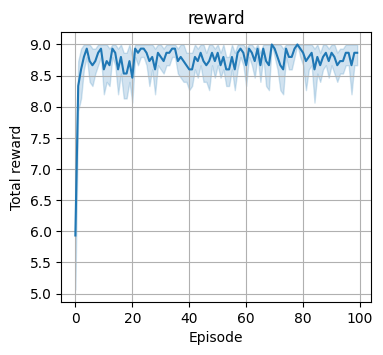

Average sum of rewards:
 model
SARSA    131.21
Name: reward, dtype: float64

Episode termination percentage:
 model
SARSA    1500.0
Name: done, dtype: float64


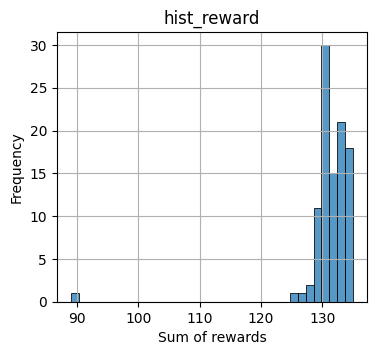

In [26]:
# Create environment
env = ABC()

# Como se puede ver en las imagenes, alfa=0.1 y gamma=0.8
# Moverse de la derecha ocurre con probabilidad 0.9 (epsilon), sin embargo,
# tengamos en cuenta lo siguiente:

# Durante el proceso de aprendizaje, queremos que el agente pruebe distintos cursos de acción, 
# de manera tal que tenga una mayor confianza en que está llegando a una política óptima. 
# No obstante, a la hora de poner a marchar al agente en producción, queremos que el agente 
# tenga su mejor desempeño. Para ello, necesitamos poner su parámetro 𝜖 en 0.

"""
Orden parametros 

self.parameters = parameters
self.nS = self.parameters['nS']
self.nA = self.parameters['nA']
self.gamma = self.parameters['gamma']
self.epsilon = self.parameters['epsilon']
"""

parameters = {\
    'nS': 3,\
    'nA': 2,\
    'gamma': 0.8,\
    'epsilon': 0.0001,\
    'alpha': 0.1, \
}

agent = [SARSA(parameters=parameters)]

# Create experiment
experiment = Experiment(environment=env,\
                 env_name='ABC', \
                 num_rounds=100, \
                 num_episodes=100, \
                 num_simulations=15)

# Use stored agents to run test
experiment.run_experiment(
                agents=agent,\
                names=['SARSA'], \
                measures=['reward', 'hist_reward'],\
                learn=True)


**Despues del entrenamiento**

Running simulations:   0%|          | 0/15 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/100 [00:00<?, ?it/s]

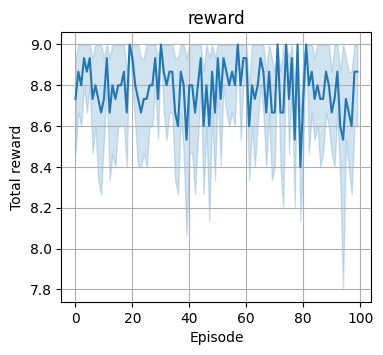

Average sum of rewards:
 model
SARSA    131.8
Name: reward, dtype: float64

Episode termination percentage:
 model
SARSA    1500.0
Name: done, dtype: float64


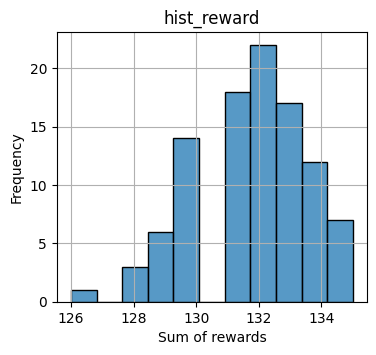

In [27]:
# Use stored agents to run test
experiment.run_experiment(
                agents=agent,\
                names=['SARSA'], \
                measures=['reward', 'hist_reward'],\
                learn=False) #Notese que learn=False


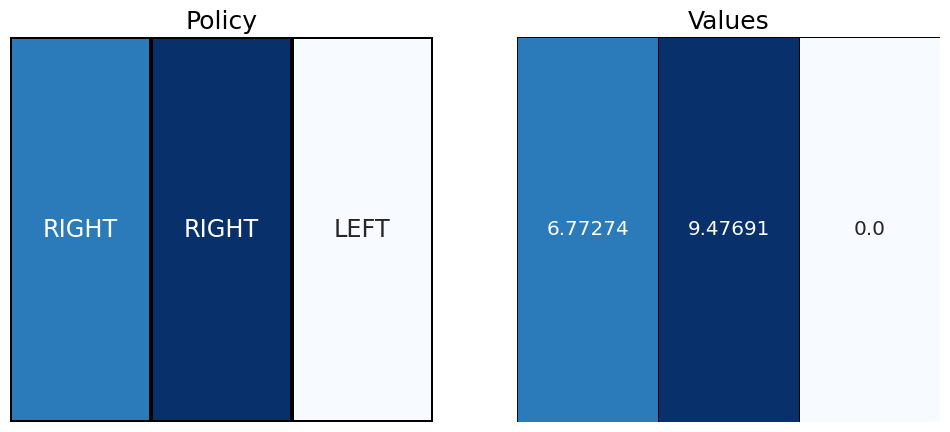

In [29]:
shape = (1,3)
pp = PlotGridValues(shape=shape, action_dict=env.dict_acciones)
sarsa = agent[0]
p = sarsa.policy
q = sarsa.Q
policy = [np.argmax(p[s,]) for s in range(env.nS)]
policy = np.flipud(np.reshape(policy, shape))
V = [np.round(np.max(q[s,]),5) for s in range(env.nS)]
pp.plot_policy_and_values(policy,V)

## Entorno Frozen Lake: Q-learning


Running simulations:   0%|          | 0/15 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

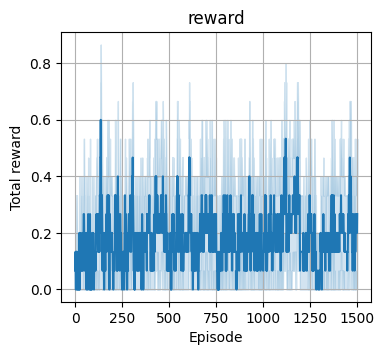

Average sum of rewards:
 model
Q_learning    2.678667
Name: reward, dtype: float64

Episode termination percentage:
 model
Q_learning    1482.733333
Name: done, dtype: float64


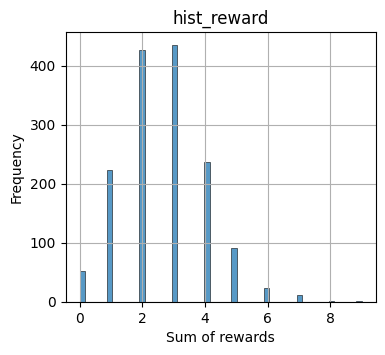

In [32]:
# Create environment

size = 4
max_rounds = 50
env = gym.make('FrozenLake-v1', 
               desc=["SFFF", "FFHF", "FHFF", "FFFG"], 
               map_name="4x4",
               is_slippery=True, 
               render_mode='rgb_array'
              )

env = TimeLimit(env, max_episode_steps=max_rounds)
env.reset()

parameters = {\
    'nS': size*size,\
    'nA': env.action_space.n,\
    'gamma': 0.99,\
    'epsilon': 0,\
    'alpha': 0.1, \
}

agent = [Q_learning(parameters=parameters)]

dict_acciones = {0:"⬅", 1:"⬇", 2:"➡", 3:"⬆"}
dict_states = dict(zip([s for s in range(16)], [np.unravel_index(s, (4,4)) for s in range(16)]))
setattr(env, 'nS', size*size)
setattr(env, 'nA', 4)
setattr(env, 'dict_acciones', dict_acciones)
setattr(env, 'dict_states', dict_states)

experiment = Experiment(environment=env,\
                 env_name='FrozenLake', \
                 num_rounds=100, \
                 num_episodes=1500, \
                 num_simulations=15, \
                 state_interpreter=gym_interpreter1)


# Use stored agents to run test
experiment.run_experiment(
                agents=agent,\
                names=['Q_learning'], \
                measures=['reward', 'hist_reward'],\
                learn=True)

**Despues del entrenamiento**

Running simulations:   0%|          | 0/15 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

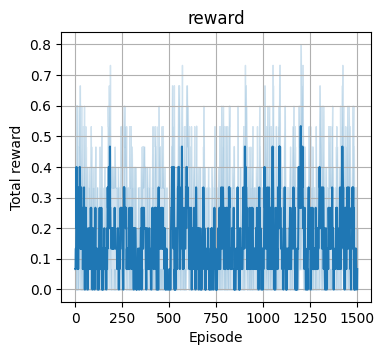

Average sum of rewards:
 model
Q_learning    2.358
Name: reward, dtype: float64

Episode termination percentage:
 model
Q_learning    1500.0
Name: done, dtype: float64


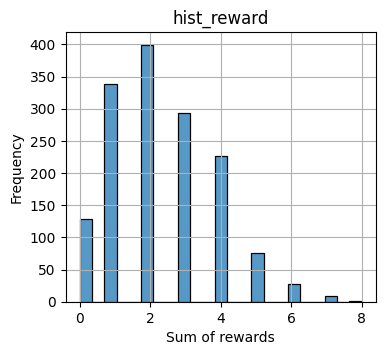

In [33]:
experiment.run_experiment(
                agents=agent,\
                names=['Q_learning'], \
                measures=['reward', 'hist_reward'],\
                learn=False) #Notese que learn=False

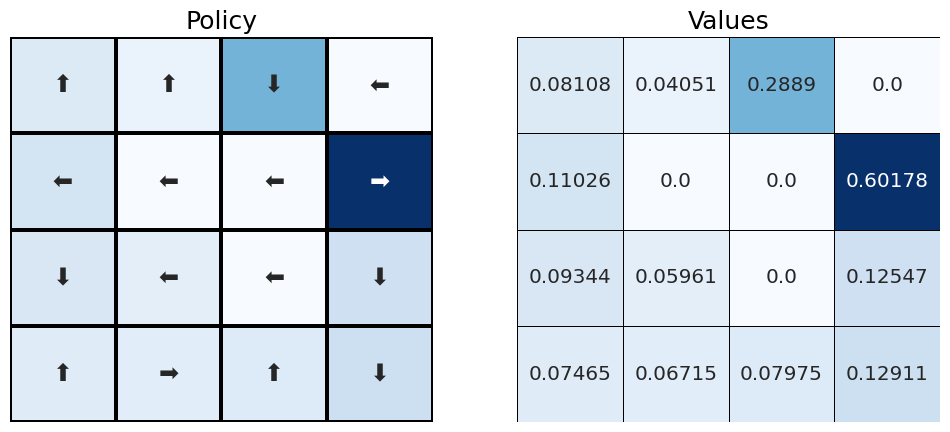

In [34]:
shape=(4,4)
pp = PlotGridValues(shape=shape, action_dict=env.dict_acciones)
q_agent = agent[0]
p = q_agent.policy
q = q_agent.Q
policy = [np.argmax(p[s,]) for s in range(env.nS)]
V = [np.round(np.max(q[s,]), 5) for s in range(env.nS)]
pp.plot_policy_and_values(policy, V)

## Entorno taxi: Q-learning


Moviepy - Building video C:\Users\David\Downloads\Notebooks_sol\TD\TaxiDriver/rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\David\Downloads\Notebooks_sol\TD\TaxiDriver/rl-video-episode-0.mp4



TypeError: must be real number, not NoneType

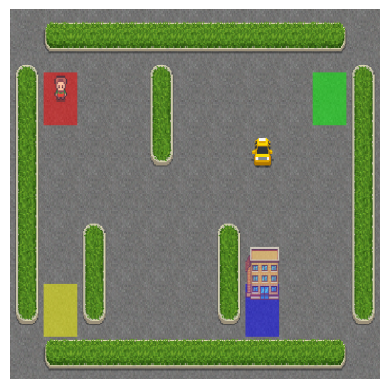

In [65]:
# Create environment
env = gym.make('Taxi-v3', \
               render_mode='rgb_array')

env = TimeLimit(env, max_episode_steps=100)

size=500
# Create agent
parameters = {
    "nS": size*size,
    "nA": env.action_space.n,
    "gamma":0.99,
    "epsilon":0.0001,
    'alpha': 0.1
}


#Entrenamiento del agente
agent = [Q_learning(parameters=parameters)]

experiment = Experiment(environment=env,\
                 env_name='Taxi', \
                 num_rounds=100, \
                 num_episodes=1500, \
                 num_simulations=10, \
                 state_interpreter=gym_interpreter1)

# Use stored agents to run test
experiment.run_experiment(
                agents=agent,\
                names=['Q_learning'], \
                measures=['reward', 'hist_reward'],\
                learn=True)

#Video con el agente no entrenado
#---------------------------------------------------------
agent2 = Agent(parameters=parameters)
# Create episode
episodio = Episode(environment=env,\
                   env_name='TaxiDriver',\
                   agent=agent2,\
                   model_name='Random',\
                   num_rounds=50, \
                   state_interpreter=gym_interpreter1)
# Visualize
episodio.renderize(to_video=True, file='TaxiDriver')
#---------------------------------------------------------


**Despues del entrenamiento**

In [61]:
experiment.run_experiment(
                agents=agent,\
                names=['Q_learning'], \
                measures=['reward', 'hist_reward'],\
                learn=False)

TypeError: 'Agent' object is not subscriptable

In [66]:
dict_acciones = {0:"⬇", 1:"⬆", 2:"➡",  3:"⬅", 4:"P", 5:"D"}
dict_states = dict(zip([s for s in range(25)], [np.unravel_index(s, (5,5)) for s in range(25)]))
setattr(env, 'dict_acciones', dict_acciones)
setattr(env, 'dict_states', dict_states)
setattr(env, 'nS', 25)
setattr(env, 'nA', 6)

Valores Q de cada estado:

[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.71995307 -2.66519075 -2.7599249  -2.66519075 -2.70180328 -2.997001  ]
 [-2.05293037 -1.97348051 -2.05330698 -1.98111352 -2.00779563 -1.999     ]
 ...
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]
250000


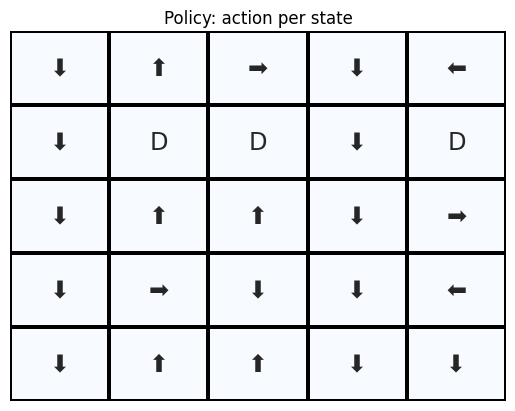

In [67]:
pp = PlotGridValues(shape=(5,5), action_dict=env.dict_acciones)
q_agent = agent[0]
p = q_agent.policy
policy = [np.argmax(p[s,]) for s in range(env.nS)]
pp.plot_policy(policy)


print(f'Valores Q de cada estado:\n\n{q_agent.Q}')
print(len(q_agent.Q))

## Entorno Blackjack

Running simulations:   0%|          | 0/10 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

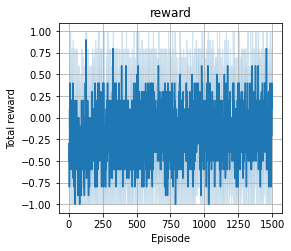

Average sum of rewards:
 model
Q_learning   -1.760667
Name: reward, dtype: float64

Episode termination percentage:
 model
Q_learning    1000.0
Name: done, dtype: float64


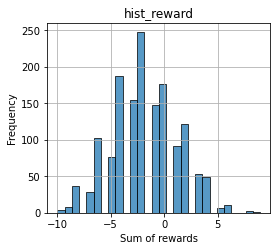

In [136]:
# Create environment

env = gym.make('Blackjack-v1', \
               render_mode='rgb_array')

env = TimeLimit(env, max_episode_steps=100)
env.reset()


#print(env.observation_space)
#print(env.action_space.n)


dict_acciones = {0:"Stick", 1:"Hit"}
setattr(env, 'nS', 32*11*2)
setattr(env, 'nA', env.action_space.n)
setattr(env, 'dict_acciones', dict_acciones)


parameters = {\
    'nS': 32*11*2,\
    'nA': env.action_space.n,\
    'gamma': 0.9,\
    'epsilon': 0,\
    'alpha': 0.1, \
}

agent = [Q_learning(parameters=parameters)]

experiment = Experiment(environment=env,\
                 env_name='Blackjack', \
                 num_rounds=100, \
                 num_episodes=1500, \
                 num_simulations=10, \
                 state_interpreter=gym_interpreter1)


# Use stored agents to run test
experiment.run_experiment(
                agents=agent,\
                names=['Q_learning'], \
                measures=['reward', 'hist_reward'],\
                learn=True)

Running simulations:   0%|          | 0/10 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

	Running episodes:   0%|          | 0/1500 [00:00<?, ?it/s]

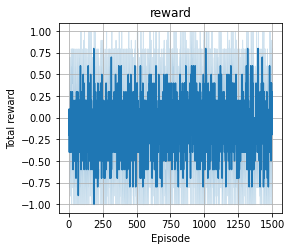

Average sum of rewards:
 model
Q_learning   -1.147333
Name: reward, dtype: float64

Episode termination percentage:
 model
Q_learning    1000.0
Name: done, dtype: float64


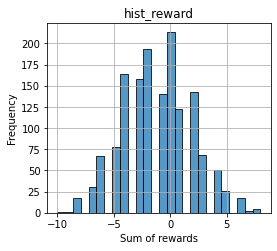

In [137]:
experiment.run_experiment(
                agents=agent,\
                names=['Q_learning'], \
                measures=['reward', 'hist_reward'],\
                learn=False)
